In [1]:
print("Welcome to my EMR Notebook!")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1597523960888_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Welcome to my EMR Notebook!

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1597523960888_0001,pyspark,idle,Link,Link,✔


In [3]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.9.0  
boto                       2.49.0 
jmespath                   0.9.5  
lxml                       4.5.0  
mysqlclient                1.4.2  
nltk                       3.4.5  
nose                       1.3.4  
numpy                      1.16.5 
pip                        9.0.1  
py-dateutil                2.2    
python37-sagemaker-pyspark 1.3.0  
pytz                       2019.3 
PyYAML                     5.3.1  
setuptools                 28.8.0 
six                        1.13.0 
soupsieve                  1.9.5  
wheel                      0.29.0 
windmill                   1.6

In [4]:
sc.install_pypi_package("pandas==0.25.1") #Install pandas version 0.25.1 
sc.install_pypi_package("matplotlib") #Install matplotlib from given PyPI repository
sc.install_pypi_package("seaborn==0.10.1") #Install seaborn version 0.10.1
sc.install_pypi_package("ipython==7.17.0") #install ipython version 7.17.0

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'SparkContext' object has no attribute 'list_packages'
Traceback (most recent call last):
AttributeError: 'SparkContext' object has no attribute 'list_packages'



In [1]:
# import libraries
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession,Window
from pyspark.sql.types import *
from pyspark.sql.functions import *

import re
import datetime

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# session overview
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.driver.host', 'b904597f18a2'),
 ('spark.app.name', 'Sparkify'),
 ('spark.app.id', 'local-1598432353507'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '33415')]

In [4]:
spark

## Load and Clean Dataset
Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [5]:
# big data on cloud
#user_log = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json" 

#mini data on cloud
#user_log = "s3://aws-emr-resources-057584263306-eu-central-1/notebooks/e-1DYCDZU9IGL1MSTRN75J0HLSI/mini_sparkify_event_data.json" 

# mini data local
user_log = "mini_sparkify_event_data.json" 
df = spark.read.json(user_log)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [35]:
# check columns
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# show first 5 rows
df.show(n=5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [8]:
# count rows
df.count()

286500

In [9]:
### Get count of both null and missing values in pyspark
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [10]:
# check "userId" with missing "firstName"
df.select(['userId']).where(df.firstName.isNull()).dropDuplicates().show()

+------+
|userId|
+------+
|      |
+------+



In [7]:
# show userId who's first name is missing
#df.where(df.userId == "1261737").show() # on whole data
df.where(df.userId == "").show(5) # on mini data

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [8]:
# count rows with "userId" as 1261737
#df.where(df.userId == "1261737").count() # on whole data
df.where(df.userId == "").count() # on mini data

8346

In [6]:
# delete rows with "userId" as 1261737
#df_clean = df.filter(df.userId != "1261737") #on the whole data 
df_clean = df.filter(df.userId != "") #on the mini data 
df_clean.count()

278154

In [10]:
# check unique userId 
df_clean.select('userId').dropDuplicates().count()

225

In [16]:
# check rows with missing value in "artist" 
df_clean.where(df_clean.artist.isNull()).show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

In [11]:
# list activities of a user who has a missing value in the artist column 1009070
# df_clean.select(["artist","userId", "firstname", "page", "level", "song"]).where(df_clean.userId == "1009070").show() # on whole data
df_clean.select(["artist","userId", "firstname", "page", "level", "song"]).where(df_clean.userId == "30").show() # on mini data

+--------------------+------+---------+---------------+-----+--------------------+
|              artist|userId|firstname|           page|level|                song|
+--------------------+------+---------+---------------+-----+--------------------+
|      Martha Tilston|    30|    Colin|       NextSong| paid|           Rockpools|
|        Adam Lambert|    30|    Colin|       NextSong| paid|   Time For Miracles|
|           Daft Punk|    30|    Colin|       NextSong| paid|Harder Better Fas...|
|        Starflyer 59|    30|    Colin|       NextSong| paid|Passengers (Old A...|
|                null|    30|    Colin|Add to Playlist| paid|                null|
|            Frumpies|    30|    Colin|       NextSong| paid|          Fuck Kitty|
|Edward Sharpe & T...|    30|    Colin|       NextSong| paid|                Jade|
|         Stan Mosley|    30|    Colin|       NextSong| paid|   So-Called Friends|
|             Orishas|    30|    Colin|       NextSong| paid|           Represent|
|   

In [52]:
#check page related to "null" artist
page_count = df_clean.select('page').where(df_clean.artist.isNull()).groupBy('page').count()\
    .orderBy('count', ascending=False).show()

# there is no "next song" page in the listed page categories, artist name is "null" for all the other pages, except "next song" page

+--------------------+-----+
|                page|count|
+--------------------+-----+
|           Thumbs Up|12551|
|                Home|10082|
|     Add to Playlist| 6526|
|          Add Friend| 4277|
|         Roll Advert| 3933|
|              Logout| 3226|
|         Thumbs Down| 2546|
|           Downgrade| 2055|
|            Settings| 1514|
|                Help| 1454|
|             Upgrade|  499|
|               About|  495|
|       Save Settings|  310|
|               Error|  252|
|      Submit Upgrade|  159|
|    Submit Downgrade|   63|
|              Cancel|   52|
|Cancellation Conf...|   52|
+--------------------+-----+



### Digging in the missing values

In [7]:
# delete missing values in "artist" column
df_no_null = df_clean.filter(df_clean.artist != "")

### Get count of both null and missing values
df_no_null.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_no_null.columns]).show() 
# there is no missing value in any column after deleting missing "artist"
df_no_null.count()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



228108

In [29]:
# check unique userId 
df_no_null.select('userId').dropDuplicates().count() # unique userId number did not change

225

In [22]:
# check tags in categorical columns
for item in ['auth','gender','level','method','page','sessionId','status','userAgent','location']:
    df_clean.select(item).dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+------+
|gender|
+------+
|     F|
|     M|
+------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   PUT|
|   GET|
+------+

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

+---------+
|sessionId|
+---------+
|       29|
|       26|
|      474|
|      964|
|     1697|
|     1806|
|     2040|
|     1950|
|     2214|
|      418|
|       65|
|      541|
|      558|
|     1010|
|     1224|
|     1277|
|     1258

In [23]:
# check location column
df_clean.select("location").dropDuplicates().show(5) 
df_clean.select("location").dropDuplicates().count()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
+--------------------+
only showing top 5 rows



114

### Simplify "location"

In [7]:
# create column "state" with Abbreviation of US states extracted from "location" column
df_clean = df_clean.withColumn('state', trim(split(col('location'),',').getItem(1)))

In [8]:
# check unique "state" 
df_clean.select('state').dropDuplicates().count()

58

In [8]:
# drop location column
df_clean = df_clean.drop('location','firstName','lastName')

### Create 'epoch time' from timestamp

In [9]:
# convert ts to epoch time and create month, date, hour columns out of it
df_clean = df_clean.withColumn('epoch_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
df_clean = df_clean.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
#df_clean = df_clean.withColumn('month', month(col('epoch_time')))
#df_clean = df_clean.withColumn('hour', hour(col('epoch_time')))  
df_clean.show(5)

+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-------------------+----------+
|          artist|     auth|gender|itemInSession|   length|level|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|         epoch_time|      date|
+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-------------------+----------+
|  Martha Tilston|Logged In|     M|           50|277.89016| paid|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|   CA|2018-10-01 00:01:57|2018-10-01|
|Five Iron Frenzy|Logged In|     M|           79|236.09424| free|   PUT|NextSong|1538331630000|        8|              Canada|   200|1538352180000|"

### Simplify "userAgent"

In [10]:
agent = udf(lambda x: str(re.findall(r'\((.*?)\)', x)[0].split(";")[0].split()[0]) if x is not None else None, StringType())

In [11]:
df_clean = df_clean.withColumn("agent", agent(df_clean.userAgent))

In [13]:
df_clean = df_clean.drop('userAgent')
df_clean.show(5)

+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+-------------+------+-----+-------------------+----------+-----+-------+
|          artist|     auth|gender|itemInSession|   length|level|method|    page| registration|sessionId|                song|status|           ts|userId|state|         epoch_time|      date|month|  agent|
+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+-------------+------+-----+-------------------+----------+-----+-------+
|  Martha Tilston|Logged In|     M|           50|277.89016| paid|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|    30|   CA|2018-10-01 00:01:57|2018-10-01|   10|Windows|
|Five Iron Frenzy|Logged In|     M|           79|236.09424| free|   PUT|NextSong|1538331630000|        8|              Canada|   200|1538352180000|     9|MA-NH|2018-10-01 00:03

### Define Churn
Create a column "Churn" to use as the label for model. Using the "Cancellation Confirmation" events to define churn, which happen for both paid and free users. 

In [15]:
# find out users who churned their service
df_clean.filter("page = 'Cancellation Confirmation'").show(5,False)

+------+---------+------+-------------+------+-----+------+-------------------------+-------------+---------+----+------+-------------+------+-----------+-------------------+----------+-----+---------+
|artist|auth     |gender|itemInSession|length|level|method|page                     |registration |sessionId|song|status|ts           |userId|state      |epoch_time         |date      |month|agent    |
+------+---------+------+-------------+------+-----+------+-------------------------+-------------+---------+----+------+-------------+------+-----------+-------------------+----------+-----+---------+
|null  |Cancelled|M     |104          |null  |paid |GET   |Cancellation Confirmation|1535623466000|514      |null|200   |1538943990000|18    |MO-KS      |2018-10-07 20:26:30|2018-10-07|10   |Macintosh|
|null  |Cancelled|M     |56           |null  |paid |GET   |Cancellation Confirmation|1537167593000|540      |null|200   |1539033046000|32    |AZ         |2018-10-08 21:10:46|2018-10-08|10   |i

In [14]:
# list activities of a user who churned the service
df_clean.select(["userId","ts","page", "level", "song"]).where(df_clean.userId == "18").show() #on mini data
#df_clean.select(["userId", "ts", "auth","page", "level"]).where(df_clean.userId == "1768454").sort("ts").show() #on whole data

+------+-------------+--------+-----+--------------------+
|userId|           ts|    page|level|                song|
+------+-------------+--------+-----+--------------------+
|    18|1538499917000|    Home| paid|                null|
|    18|1538499933000|NextSong| paid|A Beggar On A Bea...|
|    18|1538500208000|NextSong| paid|...slowdance On T...|
|    18|1538500476000|NextSong| paid|       St. Apollonia|
|    18|1538500654000|NextSong| paid|      Drunk Stripper|
|    18|1538500842000|NextSong| paid|In League With Satan|
|    18|1538500856000|Settings| paid|                null|
|    18|1538501009000|NextSong| paid|           The Quest|
|    18|1538501340000|NextSong| paid|    Waking The Demon|
|    18|1538501587000|NextSong| paid|Why Do You Let Me...|
|    18|1538501740000|NextSong| paid|High (Album Version)|
|    18|1538501984000|NextSong| paid|Remember Me_ I'm ...|
|    18|1538502021000|Settings| paid|                null|
|    18|1538502124000|NextSong| paid|          Continent

In [12]:
# lable churn event,1 for churn, o for not
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_clean = df_clean.withColumn("Churn", flag_churn_event("page"))

# add churn user flag
df_clean = df_clean.withColumn("label", max('Churn').over(Window.partitionBy('UserId')))

In [18]:
# list activities of a user who churned the service
#df_clean.select(["userId", "ts","page","level","Churn","label"]).where(df_clean.userId == "1768454").show(5) #on whole data
df_clean.select(["userId", "ts","page","level","Churn","label"]).where(df_clean.userId == "18").show(5) # on mini data

+------+-------------+--------+-----+-----+-----+
|userId|           ts|    page|level|Churn|label|
+------+-------------+--------+-----+-----+-----+
|    18|1538499917000|    Home| paid|    0|    1|
|    18|1538499933000|NextSong| paid|    0|    1|
|    18|1538500208000|NextSong| paid|    0|    1|
|    18|1538500476000|NextSong| paid|    0|    1|
|    18|1538500654000|NextSong| paid|    0|    1|
+------+-------------+--------+-----+-----+-----+
only showing top 5 rows



In [19]:
df_clean.show(5)

+--------------------+---------+------+-------------+---------+-----+------+---------+-------------+---------+--------------------+------+-------------+------+-----+-------------------+----------+-----+------+-----+-----+
|              artist|     auth|gender|itemInSession|   length|level|method|     page| registration|sessionId|                song|status|           ts|userId|state|         epoch_time|      date|month| agent|Churn|label|
+--------------------+---------+------+-------------+---------+-----+------+---------+-------------+---------+--------------------+------+-------------+------+-----+-------------------+----------+-----+------+-----+-----+
|Sleeping With Sirens|Logged In|     F|            0|202.97098| free|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|100010|   CT|2018-10-08 12:58:54|2018-10-08|   10|iPhone|    0|    0|
|Francesca Battist...|Logged In|     F|            1|196.54485| free|   PUT| NextSong|1538016340000|       31|Be

### Define downgrade 

Create a column "downgraded" using the "Downgrade" events. Flag users who downgraded at least once as 1 and users who never downgraded as 0. 

In [20]:
# find out users who downgraded their service
df_clean.filter("page = 'Downgrade'").show(1)

+------+---------+------+-------------+------+-----+------+---------+-------------+---------+----+------+-------------+------+--------+-------------------+----------+-----+------+-----+-----+
|artist|     auth|gender|itemInSession|length|level|method|     page| registration|sessionId|song|status|           ts|userId|   state|         epoch_time|      date|month| agent|Churn|label|
+------+---------+------+-------------+------+-----+------+---------+-------------+---------+----+------+-------------+------+--------+-------------------+----------+-----+------+-----+-----+
|  null|Logged In|     M|           55|  null| paid|   GET|Downgrade|1536269906000|      163|null|   200|1539857842000|200002|IL-IN-WI|2018-10-18 10:17:22|2018-10-18|   10|iPhone|    0|    0|
+------+---------+------+-------------+------+-----+------+---------+-------------+---------+----+------+-------------+------+--------+-------------------+----------+-----+------+-----+-----+
only showing top 1 row



In [21]:
# list activities of a user who downgraded the service
#df_clean.select(["userId", "ts", "auth","page", "level"]).where(df_clean.userId == "1001393").sort("ts").show() # on whole data
df_clean.select(["userId", "ts", "auth","page", "level"]).where(df_clean.userId == "200002").sort("ts").show() # on mini data

+------+-------------+---------+---------------+-----+
|userId|           ts|     auth|           page|level|
+------+-------------+---------+---------------+-----+
|200002|1538393430000|Logged In|       NextSong| free|
|200002|1538393476000|Logged In|    Roll Advert| free|
|200002|1538393635000|Logged In|       NextSong| free|
|200002|1538393806000|Logged In|       NextSong| free|
|200002|1538393807000|Logged In|      Thumbs Up| free|
|200002|1538393977000|Logged In|       NextSong| free|
|200002|1538394156000|Logged In|Add to Playlist| free|
|200002|1538501988000|Logged In|       NextSong| free|
|200002|1538502256000|Logged In|       NextSong| free|
|200002|1538502641000|Logged In|       NextSong| free|
|200002|1538502773000|Logged In|       NextSong| free|
|200002|1538502918000|Logged In|    Roll Advert| free|
|200002|1538502945000|Logged In|       NextSong| free|
|200002|1538503168000|Logged In|       NextSong| free|
|200002|1538503241000|Logged In|          About| free|
|200002|15

In [13]:
# lable downgrade event,1 for downgraded, 0 for not
flag_downgrade_event = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
df_clean = df_clean.withColumn("Downgrade", flag_downgrade_event("page"))

# add downgraded user flag
df_clean = df_clean.withColumn("downgraded", max('Downgrade').over(Window.partitionBy('UserId')))

In [23]:
# list activities of a user who downgraded the service
#df_clean.select(["userId", "auth","page", "level", "downgraded","label"]).where(df_clean.userId == "1001393").sort("ts").show() # on whole data
df_clean.select(["userId", "auth","page", "level", "downgraded","label"]).where(df_clean.userId == "200002").sort("ts").show() # on whole data


+------+---------+---------------+-----+----------+-----+
|userId|     auth|           page|level|downgraded|label|
+------+---------+---------------+-----+----------+-----+
|200002|Logged In|       NextSong| free|         1|    0|
|200002|Logged In|    Roll Advert| free|         1|    0|
|200002|Logged In|       NextSong| free|         1|    0|
|200002|Logged In|       NextSong| free|         1|    0|
|200002|Logged In|      Thumbs Up| free|         1|    0|
|200002|Logged In|       NextSong| free|         1|    0|
|200002|Logged In|Add to Playlist| free|         1|    0|
|200002|Logged In|       NextSong| free|         1|    0|
|200002|Logged In|       NextSong| free|         1|    0|
|200002|Logged In|       NextSong| free|         1|    0|
|200002|Logged In|       NextSong| free|         1|    0|
|200002|Logged In|    Roll Advert| free|         1|    0|
|200002|Logged In|       NextSong| free|         1|    0|
|200002|Logged In|       NextSong| free|         1|    0|
|200002|Logged

In [14]:
# delete 'Downgrade','Churn' columns
df_clean = df_clean.drop('Downgrade','Churn')

In [15]:
df_clean.columns

['artist',
 'auth',
 'gender',
 'itemInSession',
 'length',
 'level',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'state',
 'epoch_time',
 'date',
 'agent',
 'label',
 'downgraded']

In [55]:
df_clean.count()

278154

## Explore Data
Perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. Exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
#number of stayed and churned users
df_clean.groupBy('label').agg(countDistinct('userId').alias('user_count')).show()

+-----+----------+
|label|user_count|
+-----+----------+
|    1|        52|
|    0|       173|
+-----+----------+



In [19]:
# Plotting a bar plot to show gender distribution between stayed and churned users
gender_pd = df_clean.drop_duplicates(['userId', 'gender']).groupby(['label', 'gender']).count().sort("label").toPandas()

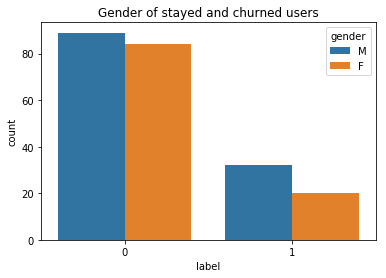

UsageError: Line magic function `%matplot` not found.


In [20]:
plt.figure()
plt.title('Gender of stayed and churned users')
sb.barplot(x = 'label', y = 'count',data = gender_pd, hue = 'gender')
plt.show()
%matplot plt # on AWS cluster

In [48]:
# Plotting a bar plot to show downgrade condition between stayed and churned users
downgrade_pd = df_clean.drop_duplicates(['userId', 'downgraded']).groupby(['label', 'downgraded']).count().sort("label").toPandas()

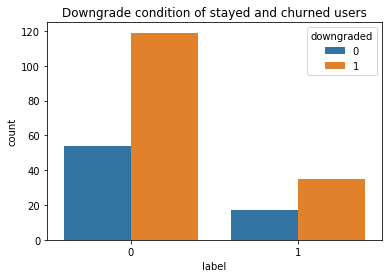

UsageError: Line magic function `%matplot` not found.


In [49]:
plt.figure()
plt.title('Downgrade condition of stayed and churned users')
sb.barplot(x = 'label', y = 'count',data = downgrade_pd, hue = 'downgraded')
plt.show()
%matplot plt # on AWS cluster

### Registered days


In [21]:
cancellation_df = df_clean.select('userId','ts').groupBy('userId').agg(max('ts').alias('lastinteraction'))
df_clean = cancellation_df.join(df_clean, on='userId').withColumn('registered_days', ((col('lastinteraction')-col('registration'))/86400000).cast(IntegerType()))
df_clean = df_clean.drop('lastinteraction','registration')
#df_clean.show(2)

In [22]:
registered_days = df_clean.select(['userId','registered_days','label']).drop_duplicates(['userId']).sort("label").toPandas()

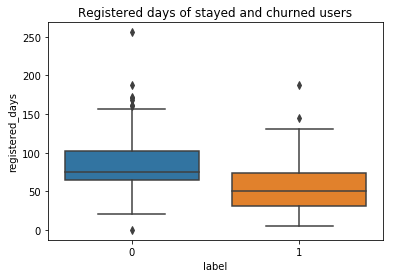

UsageError: Line magic function `%matplot` not found.


In [23]:
plt.figure()
sb.boxplot(y="registered_days", x="label", data=registered_days)
plt.title('Registered days of stayed and churned users')
plt.show()
%matplot plt # on AWS cluster

### Latest "level" of users before they churn

In [24]:
level_df = df_clean.select('ts','userId','level').orderBy('ts', ascending=False).groupBy('userId').agg(first('level').alias('valid_level'))    
df_clean = df_clean.drop('level')
df_clean = df_clean.join(level_df, on='userId')
#df_clean.show(2)

In [25]:
# Plotting a bar plot to show level of stayed and churned users
level_pd = df_clean.drop_duplicates(['userId', 'valid_level']).groupby(['label', 'valid_level']).count().sort("label").toPandas()

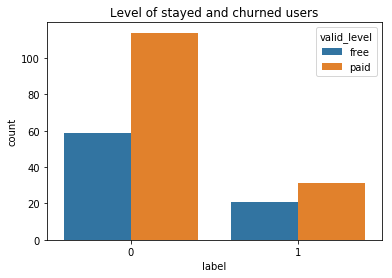

UsageError: Line magic function `%matplot` not found.


In [26]:
plt.figure()
plt.title('Level of stayed and churned users')
sb.barplot(x = 'label', y = 'count',data = level_pd, hue = 'valid_level')
plt.show()
%matplot plt  # on AWS cluster

### Number of songs per day

In [30]:
temp_daily_song = df_clean.select('userId','date','song').groupBy('userId','date').agg(countDistinct('song').alias('songs')).sort('userId')
daily_song = temp_daily_song.groupBy('userId').avg('songs').withColumnRenamed('avg(songs)', 'avg_daily_song')
df_clean = df_clean.join(daily_song, on='userId')
#df_clean.show(2)

In [31]:
# transform to pandas dataframe for plotting
avg_daily_song_pd = df_clean.select(['userId','avg_daily_song','label']).drop_duplicates(['userId']).sort("label").toPandas()

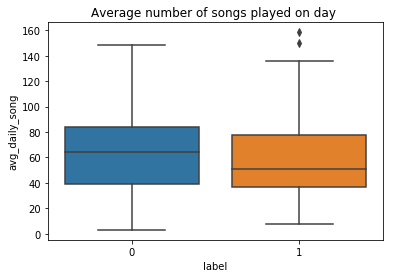

UsageError: Line magic function `%matplot` not found.


In [32]:
plt.figure()
sb.boxplot(y="avg_daily_song", x="label", data=avg_daily_song_pd)
plt.title('Average number of songs played on day ')
plt.show()
%matplot plt # on AWS cluster

### Number of songs per session

In [33]:
# create new feature
song_per_session_df = df_clean.select('page','label', 'userId', 'sessionId').where('page == "NextSong"').groupby(['label', 'userId', 'sessionId']).count()\
    .groupby(['label', 'userId']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'songs_per_session')

In [34]:
# transform to pandas dataframe for plotting
song_per_session_pd = song_per_session_df.toPandas()

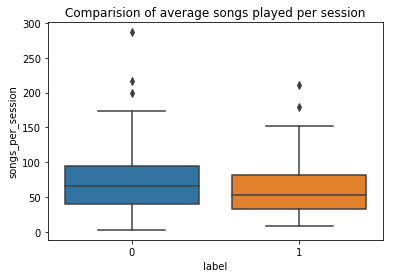

UsageError: Line magic function `%matplot` not found.


In [35]:
plt.figure()
plt.title('Comparision of average songs played per session')
sb.boxplot(y='songs_per_session', x="label", data=song_per_session_pd)
plt.show()
%matplot plt

### Daily average item per session

In [27]:
# create new feature
daily_item_df = df_clean.select('userId','date','itemInSession').groupby('userId','date').agg(max('itemInSession')).groupBy('userId').avg('max(itemInSession)').\
    withColumnRenamed('avg(max(itemInSession))', 'avg_daily_items')

# join 'avg_daily_items' column and delete 'itemInSession' column
df_clean = df_clean.join(daily_item_df, on='userId')
df_clean = df_clean.drop('itemInSession')
#df_clean.show(2)

In [28]:
# turn dataframe into pandas dataframe for plotting
avg_daily_items_pd = df_clean.select(['userId','avg_daily_items','label']).drop_duplicates(['userId']).sort("label").toPandas()

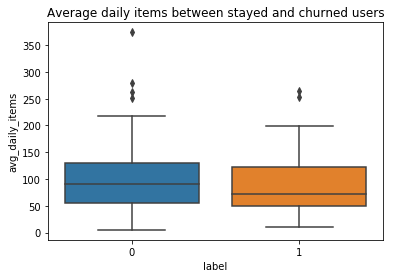

UsageError: Line magic function `%matplot` not found.


In [29]:
plt.figure()
sb.boxplot(y="avg_daily_items", x="label", data=avg_daily_items_pd)
plt.title('Average daily items between stayed and churned users')
plt.show()
%matplot plt

### Average session duration

In [36]:
# session duration for each user
session_duration = df_clean.select('userId','sessionId','ts').groupBy('userId','sessionId').agg(((max('ts')-min('ts'))/1000/3600).alias('activesession'))
# average session duration for each user
session_duration_df = session_duration.groupBy('userId').avg('activesession').withColumnRenamed('avg(activesession)', 'avg_session')

# join dataframe to create new column
df_clean = df_clean.join(session_duration_df, on='userId')

In [37]:
# create pandas dataframe for plotting
avg_session_pd = df_clean.select(['userId','avg_session','label']).drop_duplicates(['userId']).sort("label").toPandas()

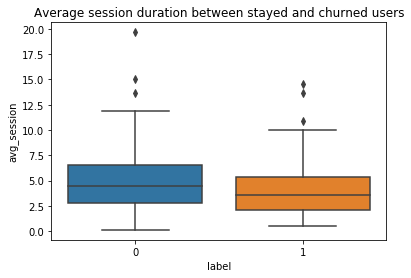

UsageError: Line magic function `%matplot` not found.


In [38]:
plt.figure()
sb.boxplot(y="avg_session", x="label", data=avg_session_pd)
plt.title('Average session duration between stayed and churned users')
plt.show()
%matplot plt

### Friends added

In [18]:
# subset data
df_page = df_clean.select('label','userId','page','date')

In [31]:
# average number of friends added daily
daily_friends_df = df_page.where('page == "Add Friend"').groupby(['label', 'userId','date']).count()\
    .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'friends')


In [32]:
daily_friends_df.show()

+-----+------+------------------+
|label|userId|           friends|
+-----+------+------------------+
|    0|100010|1.3333333333333333|
|    0|200002|               2.0|
|    0|   124|               3.7|
|    1|    51|               3.5|
|    0|     7|               1.0|
|    0|    15| 2.066666666666667|
|    1|    54| 2.357142857142857|
|    0|   155|               2.2|
|    1|100014|               1.5|
|    0|   132|2.9285714285714284|
|    0|   154|               3.0|
|    1|   101|3.2222222222222223|
|    0|    11|               1.2|
|    0|   138|               4.1|
|    0|300017|2.1724137931034484|
|    1|100021|               3.5|
|    1|    29| 3.357142857142857|
|    0|    69|1.7142857142857142|
|    0|   112|              1.75|
|    0|    42| 2.260869565217391|
+-----+------+------------------+
only showing top 20 rows



In [33]:
# turn to pandas dataframe for plotting
friends_pd = daily_friends_df.toPandas()

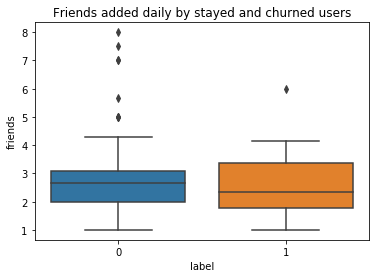

UsageError: Line magic function `%matplot` not found.


In [34]:
plt.figure()
plt.title('Friends added daily by stayed and churned users')
sb.boxplot(y="friends", x="label", data=friends_pd)
plt.show()
%matplot plt

### Number of "thumbs up"

In [35]:
# average number of "thumbs up" daily
thumbs_up_df = df_page.where('page == "Thumbs Up"').groupby(['label', 'userId','date']).count()\
    .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'thumbs_ups')

In [36]:
thumbs_up_df.show(5)

+-----+------+------------------+
|label|userId|        thumbs_ups|
+-----+------+------------------+
|    0|100010|2.8333333333333335|
|    0|200002|               3.0|
|    0|   124| 5.896551724137931|
|    1|    51| 8.333333333333334|
|    0|     7|              1.75|
+-----+------+------------------+
only showing top 5 rows



In [37]:
# turn to pandas dataframe for plotting
thumbs_up_pd = thumbs_up_df.toPandas()

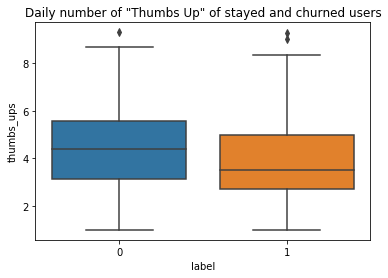

UsageError: Line magic function `%matplot` not found.


In [38]:
plt.figure()
plt.title('Daily number of "Thumbs Up" of stayed and churned users')
sb.boxplot(y="thumbs_ups", x="label", data=thumbs_up_pd)
plt.show()
%matplot plt

### Number of "thumbs down"

In [39]:
# average number of "thumbs down" daily
thumbs_down_df = df_page.where('page == "Thumbs Down"').groupby(['label', 'userId','date']).count()\
    .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'thumbs_downs')

In [40]:
# turn to pandas dataframe for plotting
thumbs_down_pd = thumbs_down_df.toPandas()

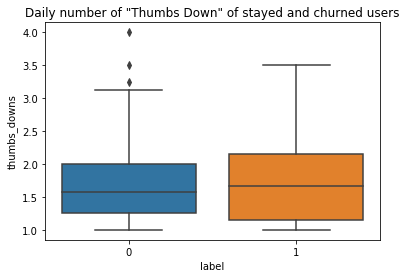

UsageError: Line magic function `%matplot` not found.


In [41]:
plt.figure()
plt.title('Daily number of "Thumbs Down" of stayed and churned users')
sb.boxplot(y="thumbs_downs", x="label", data=thumbs_down_pd)
plt.show()
%matplot plt

### Times "add to playlist"

In [42]:
# average number of "add to playlist" 
add_playlist_df = df_page.where('page == "Add to Playlist"').groupby(['label', 'userId','date']).count()\
    .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'add_playlist')

In [43]:
# turn to pandas dataframe for plotting
add_playlist_pd = add_playlist_df.toPandas()

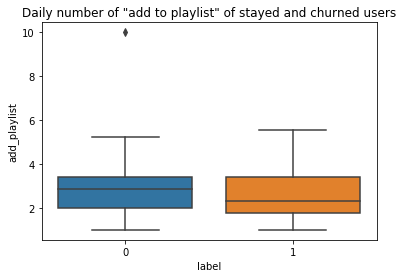

UsageError: Line magic function `%matplot` not found.


In [44]:
plt.figure()
plt.title('Daily number of "add to playlist" of stayed and churned users')
sb.boxplot(y="add_playlist", x="label", data=add_playlist_pd)
plt.show()
%matplot plt

### Times "Roll Advert"

In [45]:
# average number of "roll advert" 
roll_advert_df = df_page.where('page == "Roll Advert"').groupby(['label', 'userId','date']).count()\
    .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'roll_advert')

In [46]:
# turn to pandas dataframe for plotting
roll_advert_pd = roll_advert_df.toPandas()

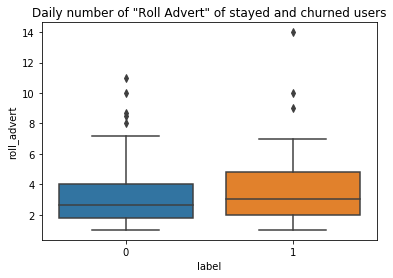

UsageError: Line magic function `%matplot` not found.


In [47]:
plt.figure()
plt.title('Daily number of "Roll Advert" of stayed and churned users')
sb.boxplot(y="roll_advert", x="label", data=roll_advert_pd)
plt.show()
%matplot plt

### Agent used by stayed and churned users

In [ ]:
# count agent frequency
device_pd = df_clean.groupBy("agent", "label").agg(countDistinct("UserId").alias("users")).sort(col("users").desc()).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

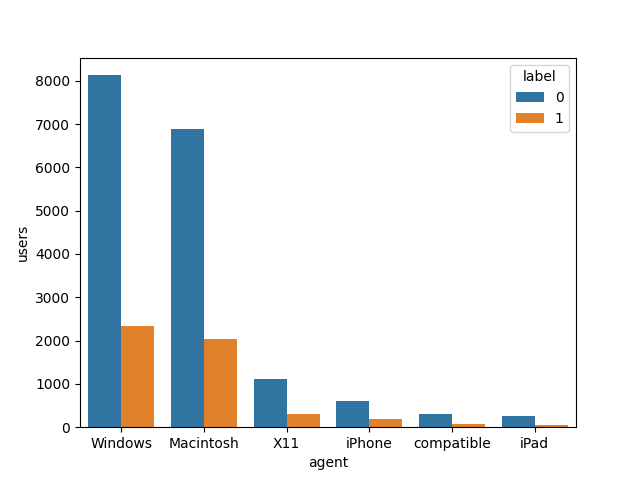

In [115]:
plt.figure()
sb.barplot(x="agent", y="users", hue="label", data=device_pd)
plt.show()
%matplot plt

### State of stayed and churned users

In [116]:
# count state frequency
state_pd = df_clean.groupBy("state", "label").agg(countDistinct("UserId").alias("users")).sort(col("users").desc()).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

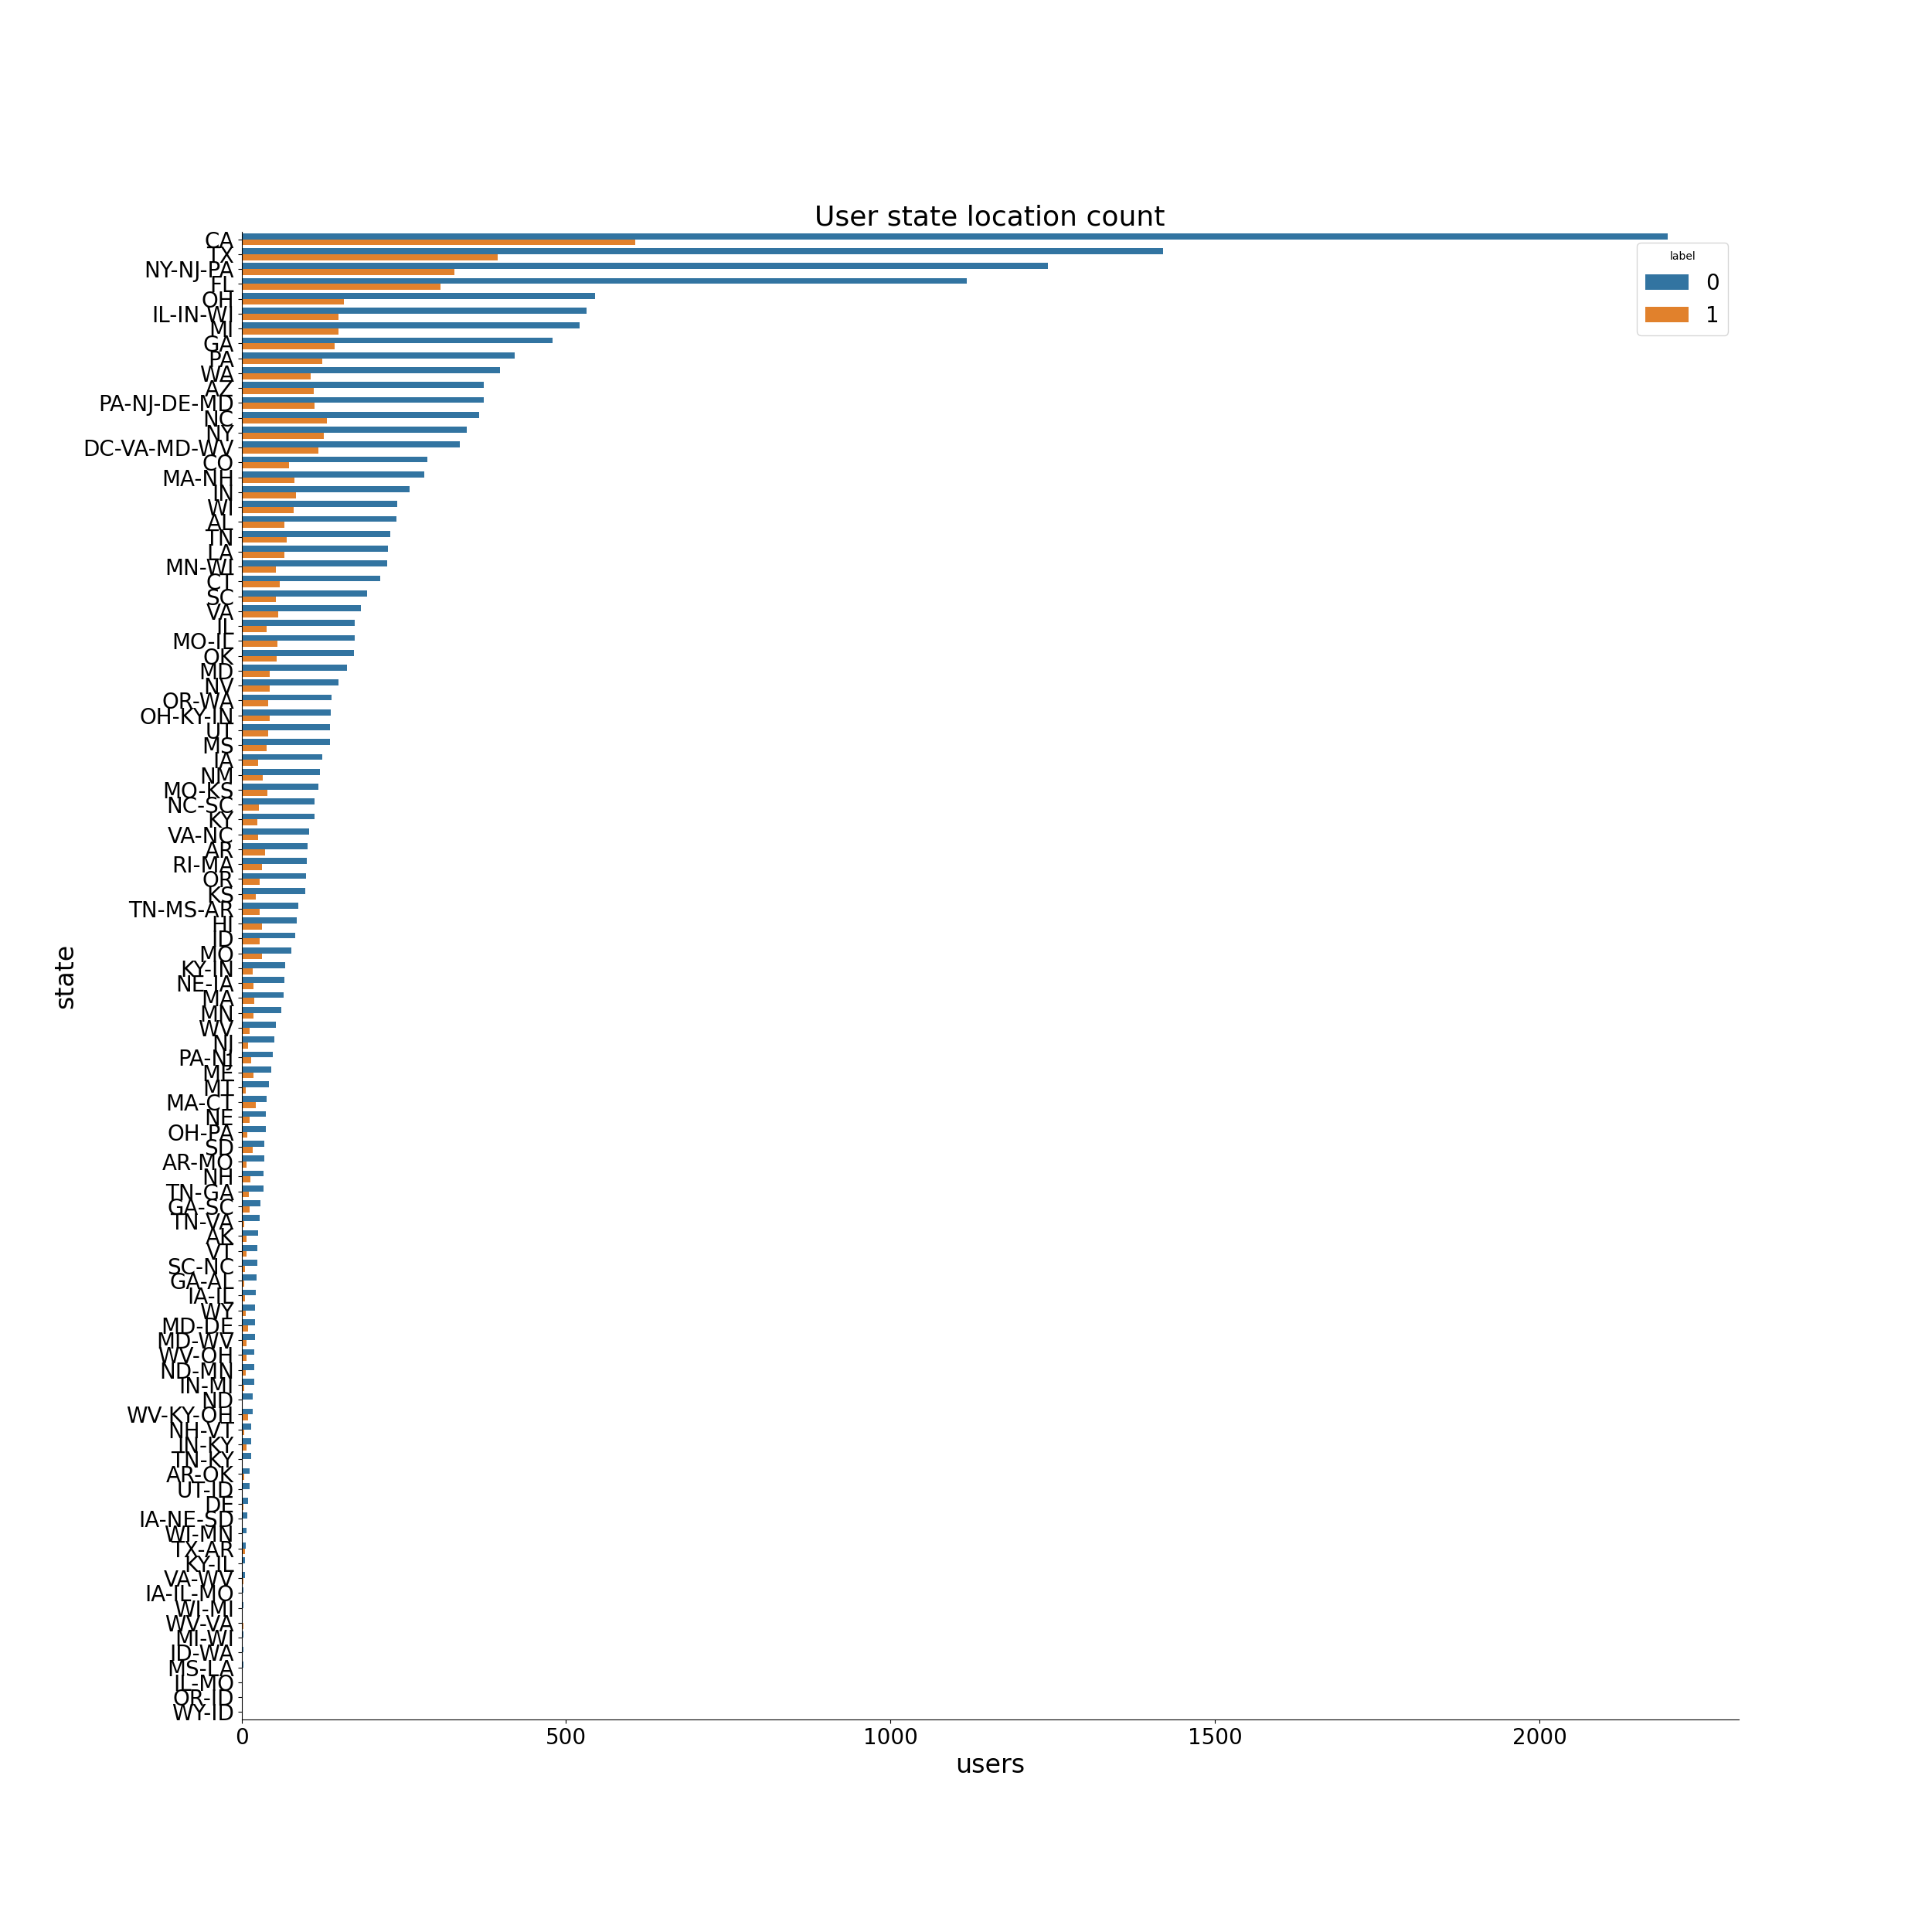

In [117]:
plt.figure(figsize=(25,25))
ax = sb.barplot(y="state", x="users", hue="label", data=state_pd)
plt.xlabel('users',fontsize=24)
plt.ylabel('state',fontsize=24)
plt.legend(title='label', loc='best',fontsize=20)
plt.title('User state location count',fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sb.despine(ax=ax)
plt.show()
%matplot plt